# Gradient boosting regressor

## Imports

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import root_mean_squared_error
from sklearn import set_config

from utils import PROCESSED_DATA_DIR, VALIDATION_CUTOFF, print_metrics

pl.Config.set_tbl_rows(20)
set_config(transform_output = "pandas")

## Data loading

In [2]:
processed_train_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('training', 'train_full.parquet')
)

processed_train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0


In [3]:
processed_train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1698818""",1.698818e6,"""1698818""","""1698818""",1.698818e6,1.698818e6,1.698818e6,1.698818e6,"""1599704""","""1599704""",1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.598505e6,1.598505e6,1.698818e6,1.698818e6,1.698818e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""99114""","""99114""",99114.0,99114.0,99114.0,99114.0,99114.0,99114.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5910.75087,"""2018-06-24""","""2018-06-07""",710.461822,17.419005,0.695564,5.91818,"""2018-07-01 06:49:28.030135""","""2018-07-01 08:45:02.581152""",115.57585,-405.751189,0.013588,2.93231,23.034132,5.301361,5721.521024,271.993762,3.944983,3.839782,0.058343
"""std""",null,4285.440264,null,null,543.207638,12.959215,0.460168,2.968049,null,null,62.670552,62.255521,0.115774,1.260417,11.898872,2.971523,2358.75767,63.198466,1.690606,1.631242,0.234391
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-30""","""2018-03-12""",395.0,8.0,0.0,4.0,"""2018-04-04 08:05:00""","""2018-04-04 10:37:00""",78.0,-420.0,0.0,2.0,9.0,3.0,2864.0,223.0,3.0,3.0,0.0
"""50%""",null,5280.0,"""2018-06-08""","""2018-05-22""",552.0,16.0,1.0,6.0,"""2018-06-20 06:05:00""","""2018-06-20 07:57:00""",89.0,-420.0,0.0,3.0,22.0,5.0,7022.0,270.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-09-24""","""2018-09-06""",825.0,26.0,1.0,8.0,"""2018-09-29 10:40:00""","""2018-09-29 12:28:00""",106.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-12-31""","""2018-12-31""",7859.0,328.0,1.0,11.0,"""2018-12-31 22:52:00""","""2019-01-01 00:26:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


## Data processing

### Train validation split

In [4]:
train_df = processed_train_df.filter(
    pl.col('flt_departure_dt') <= VALIDATION_CUTOFF
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0


In [5]:
train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1620806""",1.620806e6,"""1620806""","""1620806""",1.620806e6,1.620806e6,1.620806e6,1.620806e6,"""1523997""","""1523997""",1.523997e6,1.523997e6,1.523997e6,1.523997e6,1.523997e6,1.523997e6,1.520493e6,1.520493e6,1.620806e6,1.620806e6,1.620806e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""96809""","""96809""",96809.0,96809.0,96809.0,96809.0,96809.0,96809.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5911.562446,"""2018-06-15""","""2018-05-29""",697.322285,17.304704,0.729042,5.928195,"""2018-06-22 13:19:10.817422""","""2018-06-22 15:14:39.224408""",115.47345,-403.738236,0.013599,2.935314,23.123328,5.324437,5748.60474,272.050922,3.950592,3.838831,0.059729
"""std""",null,4281.640189,null,null,476.82029,12.891268,0.444454,2.967564,null,null,62.571682,61.889884,0.11582,1.260946,11.935589,2.988367,2368.714829,63.186493,1.69039,1.628628,0.236984
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-28""","""2018-03-10""",395.0,8.0,0.0,4.0,"""2018-04-01 19:30:00""","""2018-04-01 20:59:00""",78.0,-420.0,0.0,2.0,9.0,3.0,2864.0,223.0,3.0,3.0,0.0
"""50%""",null,5274.0,"""2018-05-29""","""2018-05-12""",545.0,16.0,1.0,6.0,"""2018-06-10 08:00:00""","""2018-06-10 10:13:00""",89.0,-420.0,0.0,3.0,23.0,5.0,7054.0,271.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-09-09""","""2018-08-23""",815.0,26.0,1.0,8.0,"""2018-09-15 14:57:00""","""2018-09-15 16:44:00""",105.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-12-15""","""2018-12-15""",7859.0,328.0,1.0,11.0,"""2018-12-15 22:45:00""","""2018-12-16 00:02:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


In [6]:
val_df = processed_train_df.filter(
    (pl.col('flt_departure_dt') > VALIDATION_CUTOFF) & 
    (
        pl.col('flt_departure_dt') <= (VALIDATION_CUTOFF + pl.duration(days = 7))
    )
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L1""",2724,2018-12-16,2018-03-26,783,265,0,8,2018-12-16 06:35:00,2018-12-16 11:00:00,265,-360,0,1,5,2,2164,373,5,1,0
"""L1""",6517,2018-12-16,2018-03-26,1436,265,0,8,2018-12-16 16:15:00,2018-12-16 20:52:00,277,-360,0,4,5,1,2164,373,5,1,0
"""L1""",2997,2018-12-16,2018-03-26,1066,265,0,8,2018-12-16 11:34:00,2018-12-16 16:10:00,276,-360,0,2,5,1,2164,373,5,1,0
"""U1""",6385,2018-12-16,2018-10-17,410,60,0,4,2018-12-16 07:00:00,2018-12-16 08:15:00,75,-480,0,1,36,7,7128,193,3,4,0
"""U1""",6128,2018-12-16,2018-10-17,511,60,0,5,2018-12-16 09:35:00,2018-12-16 11:12:00,97,-480,0,2,21,6,5817,252,3,7,0
"""U1""",6140,2018-12-16,2018-10-17,658,60,0,5,2018-12-16 13:38:00,2018-12-16 15:17:00,99,-480,0,3,21,4,5817,252,3,7,0
"""U1""",3842,2018-12-16,2018-10-17,379,60,0,4,2018-12-16 06:15:00,2018-12-16 07:25:00,70,-480,0,1,36,7,7128,193,3,4,0
"""U1""",6153,2018-12-16,2018-10-17,721,60,0,5,2018-12-16 17:00:00,2018-12-16 18:39:00,99,-480,0,4,21,7,5817,252,3,7,0
"""U1""",4771,2018-12-16,2018-10-17,457,60,0,4,2018-12-16 08:15:00,2018-12-16 09:32:00,77,-480,0,2,36,9,7128,193,3,4,0


In [7]:
val_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""34591""",34591.0,"""34591""","""34591""",34591.0,34591.0,34591.0,34591.0,"""33802""","""33802""",33802.0,33802.0,33802.0,33802.0,33802.0,33802.0,34591.0,34591.0,34591.0,34591.0,34591.0
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""789""","""789""",789.0,789.0,789.0,789.0,789.0,789.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,5782.1296,"""2018-12-19""","""2018-11-29""",877.248244,19.615536,0.0,5.726865,"""2018-12-19 14:02:30.495236""","""2018-12-19 16:00:00.319507""",117.497071,-446.318561,0.012425,2.902195,21.543134,4.931395,5175.658119,271.06944,3.837096,3.866295,0.022809
"""std""",null,4178.46838,null,null,1149.612135,16.052563,0.0,2.986408,null,null,64.655836,55.28298,0.110776,1.255698,11.121787,2.609309,2086.046551,63.136684,1.699727,1.692394,0.149298
"""min""","""L1""",752.0,"""2018-12-16""","""2018-03-06""",263.0,0.0,0.0,0.0,"""2018-12-16 01:05:00""","""2018-12-16 06:00:00""",63.0,-480.0,0.0,0.0,4.0,1.0,1618.0,165.0,0.0,0.0,0.0
"""25%""",null,2611.0,"""2018-12-17""","""2018-11-21""",395.0,9.0,0.0,4.0,"""2018-12-17 18:12:00""","""2018-12-17 19:56:00""",77.0,-480.0,0.0,2.0,9.0,3.0,2790.0,227.0,3.0,3.0,0.0
"""50%""",null,5663.0,"""2018-12-19""","""2018-12-01""",574.0,18.0,0.0,5.0,"""2018-12-19 14:45:00""","""2018-12-19 16:44:00""",90.0,-480.0,0.0,3.0,22.0,5.0,5817.0,253.0,3.0,3.0,0.0
"""75%""",null,6661.0,"""2018-12-21""","""2018-12-10""",947.0,28.0,0.0,7.0,"""2018-12-21 09:40:00""","""2018-12-21 11:18:00""",153.0,-420.0,0.0,4.0,33.0,7.0,7128.0,294.0,5.0,5.0,0.0
"""max""","""U3""",18973.0,"""2018-12-22""","""2018-12-22""",7859.0,288.0,0.0,11.0,"""2018-12-22 22:52:00""","""2018-12-23 00:32:00""",302.0,-300.0,1.0,5.0,36.0,10.0,7128.0,405.0,7.0,7.0,1.0


### Fare rescaling

#### Check if any (`route`, `carrier`) pair is missing in `train_df`

In [8]:
train_df.group_by('route_id', 'carrier').len().drop('len').join(
    val_df.group_by('route_id', 'carrier').len().drop('len'),
    on = ['route_id', 'carrier'],
    how = 'outer'
).null_count()

route_id,carrier,route_id_right,carrier_right
u32,u32,u32,u32
0,0,4,4


#### Calculating range of log of fares by (`route`, `carrier`)

In [9]:
train_df.group_by('route_id', 'carrier').agg(
    (pl.col('total_fare').max() / pl.col('total_fare').mean()).alias('up_range'),
    (pl.col('total_fare').min() / pl.col('total_fare').mean()).alias('down_range')
).describe()

statistic,route_id,carrier,up_range,down_range
str,f64,str,f64,f64
"""count""",34.0,"""34""",34.0,34.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",5.588235,null,5.3674,0.461658
"""std""",3.239132,null,3.813741,0.077132
"""min""",0.0,"""L1""",2.05318,0.278793
"""25%""",3.0,null,2.850526,0.418381
"""50%""",5.0,null,4.500058,0.466559
"""75%""",8.0,null,6.649254,0.524528
"""max""",11.0,"""U3""",18.683997,0.584841


In [10]:
base_log10_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').log10().mean().alias('base_fare'),
    pl.col('total_fare').log10().std().alias('std_fare'),
    pl.col('total_fare').log10().min().alias('min_fare'),
    pl.col('total_fare').log10().max().alias('max_fare')
).sort('route_id', 'carrier')

base_log10_fares

route_id,carrier,base_fare,std_fare,min_fare,max_fare
u8,str,f64,f64,f64,f64
0,"""L1""",2.871156,0.195093,2.472756,3.764923
0,"""U3""",2.72147,0.141055,2.468347,3.099681
1,"""L1""",2.986374,0.197644,2.638489,3.749659
2,"""L1""",2.931865,0.207182,2.472756,3.725503
2,"""OTH""",2.760548,0.162441,2.448706,3.170555
2,"""U3""",2.701619,0.194855,2.418301,3.237795
3,"""L1""",2.970955,0.217929,2.472756,3.730621
3,"""OTH""",2.765197,0.175297,2.448706,3.170555
3,"""U3""",2.808008,0.214577,2.418301,3.169674


In [11]:
base_log10_fares.select(pl.col(pl.Float64())).describe()

statistic,base_fare,std_fare,min_fare,max_fare
str,f64,f64,f64,f64
"""count""",34.0,34.0,34.0,34.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2.778057,0.184021,2.480716,3.479345
"""std""",0.131111,0.027689,0.089621,0.267785
"""min""",2.581777,0.133646,2.369216,3.05423
"""25%""",2.669455,0.162441,2.418301,3.251881
"""50%""",2.764205,0.183566,2.472756,3.555215
"""75%""",2.871156,0.204111,2.489958,3.725503
"""max""",3.0167,0.247081,2.669317,3.895367


In [12]:
train_df = train_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

train_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",1.620806e6
"""null_count""",0.0
"""mean""",-4.2467e-7
"""std""",0.069398
"""min""",-0.1677
"""25%""",-0.0514
"""50%""",-0.0134
"""75%""",0.0403
"""max""",0.5088


In [13]:
val_df = val_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

val_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",34591.0
"""null_count""",0.0
"""mean""",0.010317
"""std""",0.105171
"""min""",-0.1677
"""25%""",-0.0577
"""50%""",-0.0191
"""75%""",0.0569
"""max""",0.5088


In [14]:
train_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",6523,2018-03-06,2018-02-26,297,8,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",6523,2018-03-06,2018-02-27,297,7,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",5663,2018-03-09,2018-02-25,297,12,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",5663,2018-03-09,2018-02-26,297,11,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",5663,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 12:17:00,2018-03-10 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",6294,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 13:45:00,2018-03-10 18:43:00,298,-480,0,3,8,3,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",3861,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 15:55:00,2018-03-10 20:52:00,297,-480,0,3,8,3,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",6523,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.970955,2.472756,-0.1677
"""L1""",6523,2018-03-10,2018-02-24,297,14,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.970955,2.472756,-0.1677


In [15]:
val_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",2149,2018-12-18,2018-11-05,297,43,0,3,2018-12-18 01:00:00,2018-12-18 05:54:00,294,-480,0,0,8,1,2790,405,3,2,0,2.970955,2.472756,-0.1677
"""L1""",2149,2018-12-18,2018-11-09,297,39,0,3,2018-12-18 01:00:00,2018-12-18 05:54:00,294,-480,0,0,8,1,2790,405,3,2,0,2.970955,2.472756,-0.1677
"""L1""",2149,2018-12-18,2018-11-16,297,32,0,3,2018-12-18 01:00:00,2018-12-18 05:54:00,294,-480,0,0,8,1,2790,405,3,2,0,2.970955,2.472756,-0.1677
"""L1""",6523,2018-12-19,2018-11-09,297,40,0,3,2018-12-19 06:00:00,2018-12-19 10:50:00,290,-480,0,1,9,1,2790,405,3,2,0,2.970955,2.472756,-0.1677
"""L1""",6523,2018-12-19,2018-11-12,297,37,0,3,2018-12-19 06:00:00,2018-12-19 10:50:00,290,-480,0,1,9,1,2790,405,3,2,0,2.970955,2.472756,-0.1677
"""L1""",2149,2018-12-18,2018-11-20,310,28,0,3,2018-12-18 01:00:00,2018-12-18 05:54:00,294,-480,0,0,8,1,2790,405,3,2,0,2.970955,2.491362,-0.1614
"""L1""",2149,2018-12-18,2018-11-21,310,27,0,3,2018-12-18 01:00:00,2018-12-18 05:54:00,294,-480,0,0,8,1,2790,405,3,2,0,2.970955,2.491362,-0.1614
"""L1""",6523,2018-12-18,2018-11-22,310,26,0,3,2018-12-18 06:00:00,2018-12-18 10:51:00,291,-480,0,1,8,1,2790,405,3,2,0,2.970955,2.491362,-0.1614
"""L1""",2149,2018-12-18,2018-11-22,310,26,0,3,2018-12-18 01:00:00,2018-12-18 05:54:00,294,-480,0,0,8,1,2790,405,3,2,0,2.970955,2.491362,-0.1614


### Feature generation

#### Last week prices

In [16]:
route_mean_fares = train_df.group_by('route_id').agg(
    pl.col('total_fare').mean().alias('route_mean_fare')
).sort('route_id')

route_mean_fares

route_id,route_mean_fare
u8,f64
0,772.328898
1,1085.445653
2,870.424992
3,951.445763
4,559.232688
5,699.102823
6,516.050055
7,757.106133
8,1169.430536


In [17]:
route_week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_mean_fares,
    on = "route_id",
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    (
        pl.col('total_fare') / pl.col('route_mean_fare')
    ).alias('7d_route_avg')
).sort('route_id', 'flt_departure_dt')

route_week_ago_fare

route_id,flt_departure_dt,7d_route_avg
u8,date,f64
0,2018-02-17,0.957494
0,2018-02-18,0.957494
0,2018-02-19,0.957364
0,2018-02-20,0.957494
0,2018-02-21,0.957494
0,2018-02-22,1.055379
0,2018-02-23,1.007642
0,2018-02-24,0.93449
0,2018-02-25,0.914361


In [18]:
route_2week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 14)
).join(
    route_mean_fares,
    on = "route_id",
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    (
        pl.col('total_fare') / pl.col('route_mean_fare')
    ).alias('14d_route_avg')
).sort('route_id', 'flt_departure_dt')

route_2week_ago_fare

route_id,flt_departure_dt,14d_route_avg
u8,date,f64
0,2018-02-24,0.957494
0,2018-02-25,0.957494
0,2018-02-26,0.957364
0,2018-02-27,0.957494
0,2018-02-28,0.957494
0,2018-03-01,1.055379
0,2018-03-02,1.007642
0,2018-03-03,0.93449
0,2018-03-04,0.914361


In [19]:
route_carrier_mean_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').mean().alias('route_carrier_mean_fare')
).sort('route_id', 'carrier')

route_carrier_mean_fares

route_id,carrier,route_carrier_mean_fare
u8,str,f64
0,"""L1""",832.34545
0,"""U3""",555.936445
1,"""L1""",1085.445653
2,"""L1""",966.614477
2,"""OTH""",618.916742
2,"""U3""",559.28629
3,"""L1""",1065.304963
3,"""OTH""",632.662761
3,"""U3""",719.858787


In [20]:
route_carrier_week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt', 'carrier'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_carrier_mean_fares,
    on = ['route_id', 'carrier'],
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    pl.col('carrier'),
    (
        pl.col('total_fare') / pl.col('route_carrier_mean_fare')
    ).alias('7d_route_carrier_avg')
).sort('route_id', 'flt_departure_dt', 'carrier')

route_carrier_week_ago_fare

route_id,flt_departure_dt,carrier,7d_route_carrier_avg
u8,date,str,f64
0,2018-02-17,"""U3""",1.330188
0,2018-02-18,"""U3""",1.330188
0,2018-02-19,"""U3""",1.330008
0,2018-02-20,"""U3""",1.330188
0,2018-02-21,"""U3""",1.330188
0,2018-02-22,"""U3""",1.466175
0,2018-02-23,"""U3""",1.399856
0,2018-02-24,"""U3""",1.29823
0,2018-02-25,"""U3""",1.270267


In [21]:
train_df = train_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_2week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('14d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0,2.676879,2.92737,0.0936,1.0,1.0,1.0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0,2.593901,2.97174,0.1457,1.0,1.0,1.0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0,2.581777,2.448706,-0.0515,1.0,1.0,1.0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0,2.657775,2.605305,-0.0197,1.0,1.0,1.0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637585,2.710117,0.0275,1.0,1.0,1.0
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0,2.764205,3.113275,0.1263,1.0,1.0,1.0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764388,2.570543,-0.0701,1.0,1.0,1.0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0,2.986374,3.04883,0.0209,1.0,1.0,1.0


In [22]:
val_df = val_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_2week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('14d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64
"""L1""",2724,2018-12-16,2018-03-26,783,265,0,8,2018-12-16 06:35:00,2018-12-16 11:00:00,265,-360,0,1,5,2,2164,373,5,1,0,3.0167,2.893762,-0.0408,0.798736,0.897825,0.798736
"""L1""",6517,2018-12-16,2018-03-26,1436,265,0,8,2018-12-16 16:15:00,2018-12-16 20:52:00,277,-360,0,4,5,1,2164,373,5,1,0,3.0167,3.157154,0.0466,0.798736,0.897825,0.798736
"""L1""",2997,2018-12-16,2018-03-26,1066,265,0,8,2018-12-16 11:34:00,2018-12-16 16:10:00,276,-360,0,2,5,1,2164,373,5,1,0,3.0167,3.027757,0.0037,0.798736,0.897825,0.798736
"""U1""",6385,2018-12-16,2018-10-17,410,60,0,4,2018-12-16 07:00:00,2018-12-16 08:15:00,75,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.612784,-0.0094,1.888463,1.419032,1.578655
"""U1""",6128,2018-12-16,2018-10-17,511,60,0,5,2018-12-16 09:35:00,2018-12-16 11:12:00,97,-480,0,2,21,6,5817,252,3,7,0,2.794299,2.708421,-0.0307,1.547979,1.674178,1.434252
"""U1""",6140,2018-12-16,2018-10-17,658,60,0,5,2018-12-16 13:38:00,2018-12-16 15:17:00,99,-480,0,3,21,4,5817,252,3,7,0,2.794299,2.818226,0.0086,1.547979,1.674178,1.434252
"""U1""",3842,2018-12-16,2018-10-17,379,60,0,4,2018-12-16 06:15:00,2018-12-16 07:25:00,70,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.578639,-0.0223,1.888463,1.419032,1.578655
"""U1""",6153,2018-12-16,2018-10-17,721,60,0,5,2018-12-16 17:00:00,2018-12-16 18:39:00,99,-480,0,4,21,7,5817,252,3,7,0,2.794299,2.857935,0.0228,1.547979,1.674178,1.434252
"""U1""",4771,2018-12-16,2018-10-17,457,60,0,4,2018-12-16 08:15:00,2018-12-16 09:32:00,77,-480,0,2,36,9,7128,193,3,4,0,2.637585,2.659916,0.0085,1.888463,1.419032,1.578655


#### Days since start

In [23]:
train_df = train_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0,2.676879,2.92737,0.0936,1.0,1.0,1.0,0
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0,2.593901,2.97174,0.1457,1.0,1.0,1.0,0
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0,2.581777,2.448706,-0.0515,1.0,1.0,1.0,0
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0,2.657775,2.605305,-0.0197,1.0,1.0,1.0,0
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637585,2.710117,0.0275,1.0,1.0,1.0,0
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0,2.764205,3.113275,0.1263,1.0,1.0,1.0,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764388,2.570543,-0.0701,1.0,1.0,1.0,0
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0,2.986374,3.04883,0.0209,1.0,1.0,1.0,0


In [24]:
val_df = val_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64
"""L1""",2724,2018-12-16,2018-03-26,783,265,0,8,2018-12-16 06:35:00,2018-12-16 11:00:00,265,-360,0,1,5,2,2164,373,5,1,0,3.0167,2.893762,-0.0408,0.798736,0.897825,0.798736,349
"""L1""",6517,2018-12-16,2018-03-26,1436,265,0,8,2018-12-16 16:15:00,2018-12-16 20:52:00,277,-360,0,4,5,1,2164,373,5,1,0,3.0167,3.157154,0.0466,0.798736,0.897825,0.798736,349
"""L1""",2997,2018-12-16,2018-03-26,1066,265,0,8,2018-12-16 11:34:00,2018-12-16 16:10:00,276,-360,0,2,5,1,2164,373,5,1,0,3.0167,3.027757,0.0037,0.798736,0.897825,0.798736,349
"""U1""",6385,2018-12-16,2018-10-17,410,60,0,4,2018-12-16 07:00:00,2018-12-16 08:15:00,75,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.612784,-0.0094,1.888463,1.419032,1.578655,349
"""U1""",6128,2018-12-16,2018-10-17,511,60,0,5,2018-12-16 09:35:00,2018-12-16 11:12:00,97,-480,0,2,21,6,5817,252,3,7,0,2.794299,2.708421,-0.0307,1.547979,1.674178,1.434252,349
"""U1""",6140,2018-12-16,2018-10-17,658,60,0,5,2018-12-16 13:38:00,2018-12-16 15:17:00,99,-480,0,3,21,4,5817,252,3,7,0,2.794299,2.818226,0.0086,1.547979,1.674178,1.434252,349
"""U1""",3842,2018-12-16,2018-10-17,379,60,0,4,2018-12-16 06:15:00,2018-12-16 07:25:00,70,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.578639,-0.0223,1.888463,1.419032,1.578655,349
"""U1""",6153,2018-12-16,2018-10-17,721,60,0,5,2018-12-16 17:00:00,2018-12-16 18:39:00,99,-480,0,4,21,7,5817,252,3,7,0,2.794299,2.857935,0.0228,1.547979,1.674178,1.434252,349
"""U1""",4771,2018-12-16,2018-10-17,457,60,0,4,2018-12-16 08:15:00,2018-12-16 09:32:00,77,-480,0,2,36,9,7128,193,3,4,0,2.637585,2.659916,0.0085,1.888463,1.419032,1.578655,349


#### Flight date features

In [25]:
train_df = train_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85,-480,0,2,30,5,6659,212,3,4,0,2.676879,2.92737,0.0936,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80,-480,0,3,30,8,6659,316,3,4,0,2.593901,2.97174,0.1457,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65,-480,0,4,30,7,6659,316,4,3,0,2.581777,2.448706,-0.0515,1.0,1.0,1.0,0,1,1,1,1
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72,-480,0,4,30,7,6659,213,4,3,0,2.657775,2.605305,-0.0197,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88,-480,0,5,21,5,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0,1,1,1,1
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637585,2.710117,0.0275,1.0,1.0,1.0,0,1,1,1,1
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86,-480,0,4,30,7,6659,231,3,4,0,2.764205,3.113275,0.1263,1.0,1.0,1.0,0,1,1,1,1
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764388,2.570543,-0.0701,1.0,1.0,1.0,0,1,1,1,1
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204,-300,0,3,5,2,1468,360,1,5,0,2.986374,3.04883,0.0209,1.0,1.0,1.0,0,1,1,1,1


In [26]:
val_df = val_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""L1""",2724,2018-12-16,2018-03-26,783,265,0,8,2018-12-16 06:35:00,2018-12-16 11:00:00,265,-360,0,1,5,2,2164,373,5,1,0,3.0167,2.893762,-0.0408,0.798736,0.897825,0.798736,349,12,16,50,7
"""L1""",6517,2018-12-16,2018-03-26,1436,265,0,8,2018-12-16 16:15:00,2018-12-16 20:52:00,277,-360,0,4,5,1,2164,373,5,1,0,3.0167,3.157154,0.0466,0.798736,0.897825,0.798736,349,12,16,50,7
"""L1""",2997,2018-12-16,2018-03-26,1066,265,0,8,2018-12-16 11:34:00,2018-12-16 16:10:00,276,-360,0,2,5,1,2164,373,5,1,0,3.0167,3.027757,0.0037,0.798736,0.897825,0.798736,349,12,16,50,7
"""U1""",6385,2018-12-16,2018-10-17,410,60,0,4,2018-12-16 07:00:00,2018-12-16 08:15:00,75,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.612784,-0.0094,1.888463,1.419032,1.578655,349,12,16,50,7
"""U1""",6128,2018-12-16,2018-10-17,511,60,0,5,2018-12-16 09:35:00,2018-12-16 11:12:00,97,-480,0,2,21,6,5817,252,3,7,0,2.794299,2.708421,-0.0307,1.547979,1.674178,1.434252,349,12,16,50,7
"""U1""",6140,2018-12-16,2018-10-17,658,60,0,5,2018-12-16 13:38:00,2018-12-16 15:17:00,99,-480,0,3,21,4,5817,252,3,7,0,2.794299,2.818226,0.0086,1.547979,1.674178,1.434252,349,12,16,50,7
"""U1""",3842,2018-12-16,2018-10-17,379,60,0,4,2018-12-16 06:15:00,2018-12-16 07:25:00,70,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.578639,-0.0223,1.888463,1.419032,1.578655,349,12,16,50,7
"""U1""",6153,2018-12-16,2018-10-17,721,60,0,5,2018-12-16 17:00:00,2018-12-16 18:39:00,99,-480,0,4,21,7,5817,252,3,7,0,2.794299,2.857935,0.0228,1.547979,1.674178,1.434252,349,12,16,50,7
"""U1""",4771,2018-12-16,2018-10-17,457,60,0,4,2018-12-16 08:15:00,2018-12-16 09:32:00,77,-480,0,2,36,9,7128,193,3,4,0,2.637585,2.659916,0.0085,1.888463,1.419032,1.578655,349,12,16,50,7


### Imputation

#### Null counts

In [27]:
train_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,96809,96809,96809,96809,96809,96809,96809,96809,100313,100313,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
val_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,789,789,789,789,789,789,789,789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Flight duration

In [29]:
mean_durations = train_df.group_by('route_id', 'carrier').agg(
    pl.col('dur_min').mean().round(2).alias("dur_mean"),
    pl.col('dur_min').std().round(2).alias("dur_std")
).sort('route_id', 'carrier')

mean_durations

route_id,carrier,dur_mean,dur_std
u8,str,f64,f64
0,"""L1""",190.58,5.38
0,"""U3""",193.75,3.53
1,"""L1""",188.01,14.06
2,"""L1""",77.51,7.38
2,"""OTH""",73.61,7.79
2,"""U3""",94.24,1.8
3,"""L1""",296.51,3.91
3,"""OTH""",297.09,3.35
3,"""U3""",301.47,1.35


In [30]:
train_df = train_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

train_df['dur_min'].null_count()

0

In [31]:
val_df = val_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

val_df['dur_min'].null_count()

0

#### Over midnight

In [32]:
train_df = train_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

train_df['over_mn'].value_counts()

over_mn,count
i8,u32
1,20725
0,1503272
-1,96809


In [33]:
val_df = val_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

val_df['over_mn'].value_counts()

over_mn,count
i8,u32
-1,789
0,33382
1,420


#### Flight counts

In [34]:
flight_counts_daily = processed_train_df.filter(
    pl.col('flt_count_dpt_24h').is_not_null()
).group_by(
    'flt_departure_dt', 'route_id'
).agg(
    pl.col('flt_count_dpt_24h').first()
).sort('flt_departure_dt', 'route_id')

flight_counts_daily

flt_departure_dt,route_id,flt_count_dpt_24h
date,u8,u8
2018-01-01,1,5
2018-01-01,4,30
2018-01-01,6,30
2018-01-01,8,4
2018-01-01,9,7
2018-01-01,11,21
2018-01-02,1,5
2018-01-02,4,30
2018-01-02,6,30


In [35]:
train_df = train_df.join(
    flight_counts_daily,
    on = ['flt_departure_dt', 'route_id'],
    how = "left"
).with_columns(
    pl.coalesce(['flt_count_dpt_24h', 'flt_count_dpt_24h_right']),
    pl.col('flt_count_dpt_4h').fill_null(-1),
    pl.col('dpt_4h_od').fill_null(-1)
).drop('flt_count_dpt_24h_right')

train_df.select(
    pl.col('flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od').null_count()
)

flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
u32,u32,u32
0,0,0


In [36]:
val_df = val_df.join(
    flight_counts_daily,
    on = ['flt_departure_dt', 'route_id'],
    how = "left"
).with_columns(
    pl.coalesce(['flt_count_dpt_24h', 'flt_count_dpt_24h_right']),
    pl.col('flt_count_dpt_4h').fill_null(-1),
    pl.col('dpt_4h_od').fill_null(-1)
).drop('flt_count_dpt_24h_right')

val_df.select(
    pl.col('flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od').null_count()
)

flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
u32,u32,u32
0,0,0


### Training datasets

In [37]:
TRAINING_COLS = [
    'carrier', 'days_till_flight', 'origin_id', 'destination_id', 'route_id',
    'dur_min', 'flt_info_null', 'days_since_start', 'is_dst',
    'flt_departure_month', 'flt_departure_day',
    'flt_departure_week', 'flt_departure_weekday',
    '7d_route_avg', '14d_route_avg', '7d_route_carrier_avg', 'over_mn',
    'flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od'
]

X_train = train_df.select(TRAINING_COLS)
X_val = val_df.select(TRAINING_COLS)

y_train = train_df['scaled_fare']
y_val = val_df['scaled_fare']

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1620806, 20), (34591, 20), (1620806,), (34591,))

In [38]:
X_train.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,14d_route_avg,7d_route_carrier_avg,over_mn,flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1620806""",1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6,1.620806e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,17.304704,3.950592,3.838831,5.928195,113.797411,0.059729,165.957657,0.729042,6.014772,15.368825,24.280423,3.994698,1.007821,1.011601,1.008596,-0.046942,23.370649,4.946685,2.700262
"""std""",null,12.891268,1.69039,1.628628,2.967564,61.082257,0.236984,97.009138,0.444454,3.193435,8.747148,13.861955,1.998729,0.324581,0.328008,0.345847,0.265165,11.735545,3.262408,1.537781
"""min""","""L1""",0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.450929,0.450929,0.42887,-1.0,2.0,-1.0,-1.0
"""25%""",null,8.0,3.0,3.0,4.0,78.0,0.0,86.0,0.0,3.0,8.0,13.0,2.0,0.804092,0.807531,0.791476,0.0,9.0,2.0,2.0
"""50%""",null,16.0,4.0,3.0,6.0,89.0,0.0,148.0,1.0,5.0,15.0,22.0,4.0,0.929223,0.935142,0.924417,0.0,23.0,5.0,3.0
"""75%""",null,26.0,5.0,5.0,8.0,102.0,0.0,251.0,1.0,9.0,23.0,36.0,6.0,1.113469,1.113286,1.117478,0.0,35.0,8.0,4.0
"""max""","""U3""",328.0,7.0,7.0,11.0,304.0,1.0,348.0,1.0,12.0,31.0,50.0,7.0,5.030655,5.030655,4.920919,1.0,43.0,12.0,5.0


In [39]:
X_val.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,14d_route_avg,7d_route_carrier_avg,over_mn,flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""34591""",34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0,34591.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,19.615536,3.837096,3.866295,5.726865,116.566335,0.022809,352.020901,0.0,12.0,19.020901,50.8619,3.987598,1.048691,0.902292,1.099185,-0.010668,21.813564,4.796103,2.813188
"""std""",null,16.052563,1.699727,1.692394,2.986408,64.209208,0.149298,1.989535,0.0,0.0,1.989535,0.345009,1.987469,0.312414,0.235341,0.896156,0.186651,11.13866,2.727156,1.371211
"""min""","""L1""",0.0,0.0,0.0,0.0,63.0,0.0,349.0,0.0,12.0,16.0,50.0,1.0,0.567251,0.598931,0.567251,-1.0,4.0,-1.0,-1.0
"""25%""",null,9.0,3.0,3.0,4.0,77.0,0.0,350.0,0.0,12.0,17.0,51.0,2.0,0.832538,0.763113,0.725328,0.0,9.0,3.0,2.0
"""50%""",null,18.0,3.0,3.0,5.0,89.0,0.0,352.0,0.0,12.0,19.0,51.0,4.0,0.975769,0.848769,0.841999,0.0,22.0,5.0,3.0
"""75%""",null,28.0,5.0,5.0,7.0,153.0,0.0,354.0,0.0,12.0,21.0,51.0,6.0,1.161544,0.928237,1.009782,0.0,33.0,7.0,4.0
"""max""","""U3""",288.0,7.0,7.0,11.0,302.0,1.0,355.0,0.0,12.0,22.0,51.0,7.0,2.077213,1.674178,5.568013,1.0,36.0,10.0,5.0


## Modelling

### Training

In [40]:
pred_fare_expr = pl.lit(10).pow(
    (pl.col('pred_scaled_fare') * pl.col('base_fare')) + pl.col('base_fare')
).alias('pred_fare')

def get_model():
    col_transform = ColumnTransformer(
        [
            (
                'ord', 
                OrdinalEncoder(),
                ['carrier']
            )
        ],
        remainder = 'passthrough',
        sparse_threshold = 0
    )
    
    return Pipeline(
        [
            ('col_transformer', col_transform),
            (
                'gbr', 
                GradientBoostingRegressor(
                    max_depth = 4,
                    random_state = 7
                )
            )
        ]
    )

def train_model(param_grid, n_iter = 5):
    param_sampler = ParameterSampler(
        param_grid,
        n_iter = n_iter,
        random_state = 7
    )

    best_rmse = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(list(param_sampler)):
        print(f"{params}")
        model = get_model()
        model.set_params(**params)
        model.fit(X_train, y_train)

        val_preds = val_df.with_columns(
            pred_scaled_fare = model.predict(X_val)
        ).with_columns(pred_fare_expr)['pred_fare']

        rmse = root_mean_squared_error(val_df['total_fare'], val_preds)
        print(f"{i} : {rmse:.3f}\n")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print(f"Best params:\n{best_params}")
    return best_model

param_grid = {
    "gbr__loss": ['squared_error', 'absolute_error'],
    "gbr__n_estimators": np.linspace(150, 300, 4, dtype = np.int32),
    "gbr__learning_rate": [0.01, 0.02, 0.05, 0.1, 0.2]
}

best_model = train_model(param_grid, n_iter = 8)
best_model

{'gbr__n_estimators': 200, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.05}
0 : 893.776

{'gbr__n_estimators': 200, 'gbr__loss': 'absolute_error', 'gbr__learning_rate': 0.2}
1 : 861.315

{'gbr__n_estimators': 250, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.2}
2 : 754.619

{'gbr__n_estimators': 250, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.05}
3 : 828.722

{'gbr__n_estimators': 150, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.2}
4 : 755.799

{'gbr__n_estimators': 200, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.01}
5 : 1168.780

{'gbr__n_estimators': 250, 'gbr__loss': 'absolute_error', 'gbr__learning_rate': 0.05}
6 : 1171.596

{'gbr__n_estimators': 250, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.01}
7 : 1166.908

Best params:
{'gbr__n_estimators': 250, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.2}


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['carrier'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.2, max_depth=4,
                                           n_estimators=250, random_state=7))])

### Predictions

In [41]:
train_df = train_df.with_columns(
    pred_scaled_fare = best_model.predict(X_train)
).with_columns(pred_fare_expr)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,i16,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""L2""",5242,2018-01-01,2017-11-27,846,35,0,4,2018-01-01 10:49:00,2018-01-01 12:14:00,85.0,-480,0,2,30,5,6659,212,3,4,0,2.676879,2.92737,0.0936,1.0,1.0,1.0,0,1,1,1,1,86.22,0.120204,996.896858
"""OTH""",4790,2018-01-01,2017-11-27,937,35,0,4,2018-01-01 14:57:00,2018-01-01 16:17:00,80.0,-480,0,3,30,8,6659,316,3,4,0,2.593901,2.97174,0.1457,1.0,1.0,1.0,0,1,1,1,1,81.33,0.120491,806.199941
"""OTH""",4837,2018-01-01,2017-11-27,281,35,0,6,2018-01-01 19:38:00,2018-01-01 20:43:00,65.0,-480,0,4,30,7,6659,316,4,3,0,2.581777,2.448706,-0.0515,1.0,1.0,1.0,0,1,1,1,1,71.29,0.001853,385.976224
"""L2""",5314,2018-01-01,2017-11-27,403,35,0,6,2018-01-01 19:05:00,2018-01-01 20:17:00,72.0,-480,0,4,30,7,6659,213,4,3,0,2.657775,2.605305,-0.0197,1.0,1.0,1.0,0,1,1,1,1,78.14,0.010624,485.300732
"""OTH""",6187,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 20:30:00,2018-01-01 21:58:00,88.0,-480,0,5,21,5,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0,1,1,1,1,90.69,-0.073574,338.024751
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,79.76,null,-1,-1,30,-1,null,null,3,4,1,2.637585,2.710117,0.0275,1.0,1.0,1.0,0,1,1,1,1,79.76,0.098439,789.269508
"""L3""",15130,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 16:53:00,2018-01-01 18:19:00,86.0,-480,0,4,30,7,6659,231,3,4,0,2.764205,3.113275,0.1263,1.0,1.0,1.0,0,1,1,1,1,79.05,0.0949,1062.98546
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93.0,-480,0,4,21,7,6579,262,7,3,0,2.764388,2.570543,-0.0701,1.0,1.0,1.0,0,1,1,1,1,95.07,-0.072551,366.293096
"""L1""",6316,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 12:31:00,2018-01-01 15:55:00,204.0,-300,0,3,5,2,1468,360,1,5,0,2.986374,3.04883,0.0209,1.0,1.0,1.0,0,1,1,1,1,188.01,0.058317,1447.206853


In [42]:
val_df = val_df.with_columns(
    pred_scaled_fare = best_model.predict(X_val)
).with_columns(pred_fare_expr)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,i16,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""L1""",2724,2018-12-16,2018-03-26,783,265,0,8,2018-12-16 06:35:00,2018-12-16 11:00:00,265.0,-360,0,1,5,2,2164,373,5,1,0,3.0167,2.893762,-0.0408,0.798736,0.897825,0.798736,349,12,16,50,7,278.01,-0.069174,642.720189
"""L1""",6517,2018-12-16,2018-03-26,1436,265,0,8,2018-12-16 16:15:00,2018-12-16 20:52:00,277.0,-360,0,4,5,1,2164,373,5,1,0,3.0167,3.157154,0.0466,0.798736,0.897825,0.798736,349,12,16,50,7,278.01,-0.026959,861.734349
"""L1""",2997,2018-12-16,2018-03-26,1066,265,0,8,2018-12-16 11:34:00,2018-12-16 16:10:00,276.0,-360,0,2,5,1,2164,373,5,1,0,3.0167,3.027757,0.0037,0.798736,0.897825,0.798736,349,12,16,50,7,278.01,-0.022301,890.074357
"""U1""",6385,2018-12-16,2018-10-17,410,60,0,4,2018-12-16 07:00:00,2018-12-16 08:15:00,75.0,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.612784,-0.0094,1.888463,1.419032,1.578655,349,12,16,50,7,79.76,0.003923,444.561227
"""U1""",6128,2018-12-16,2018-10-17,511,60,0,5,2018-12-16 09:35:00,2018-12-16 11:12:00,97.0,-480,0,2,21,6,5817,252,3,7,0,2.794299,2.708421,-0.0307,1.547979,1.674178,1.434252,349,12,16,50,7,97.96,0.02695,740.637016
"""U1""",6140,2018-12-16,2018-10-17,658,60,0,5,2018-12-16 13:38:00,2018-12-16 15:17:00,99.0,-480,0,3,21,4,5817,252,3,7,0,2.794299,2.818226,0.0086,1.547979,1.674178,1.434252,349,12,16,50,7,97.96,0.045289,833.394203
"""U1""",3842,2018-12-16,2018-10-17,379,60,0,4,2018-12-16 06:15:00,2018-12-16 07:25:00,70.0,-480,0,1,36,7,7128,193,3,4,0,2.637585,2.578639,-0.0223,1.888463,1.419032,1.578655,349,12,16,50,7,79.76,0.000083,434.313767
"""U1""",6153,2018-12-16,2018-10-17,721,60,0,5,2018-12-16 17:00:00,2018-12-16 18:39:00,99.0,-480,0,4,21,7,5817,252,3,7,0,2.794299,2.857935,0.0228,1.547979,1.674178,1.434252,349,12,16,50,7,97.96,0.045057,832.1523
"""U1""",4771,2018-12-16,2018-10-17,457,60,0,4,2018-12-16 08:15:00,2018-12-16 09:32:00,77.0,-480,0,2,36,9,7128,193,3,4,0,2.637585,2.659916,0.0085,1.888463,1.419032,1.578655,349,12,16,50,7,79.76,0.009961,461.166718


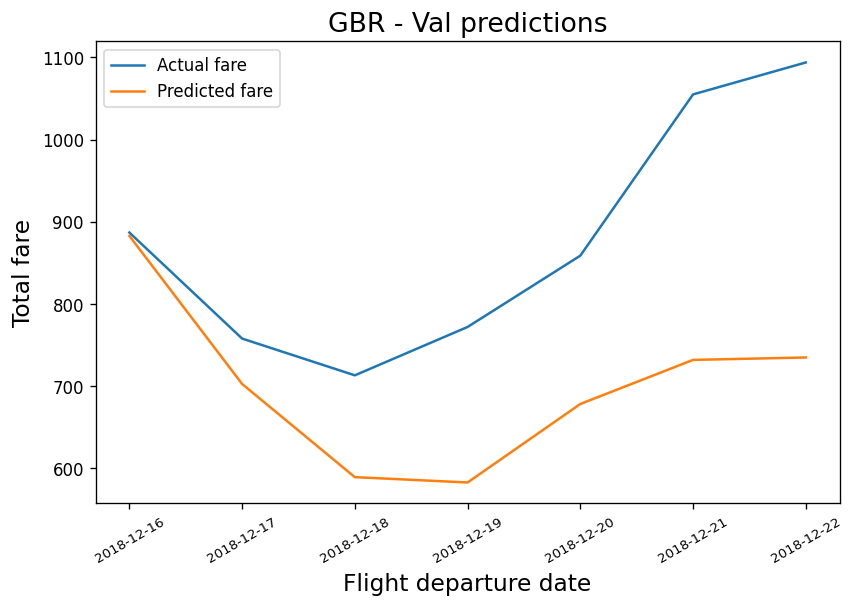

In [43]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('total_fare').mean()), 
    x = "flt_departure_dt", 
    y = "total_fare",
    label = "Actual fare"
)

sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('pred_fare').mean()), 
    x = "flt_departure_dt", 
    y = "pred_fare",
    label = "Predicted fare"
)

locs, labels = plt.xticks()
plt.xticks(
    locs,
    [l.get_text() for l in labels],
    rotation = 30,
    fontsize = 8
)

plt.legend()
plt.title("GBR - Val predictions", fontsize = 16)
plt.xlabel("Flight departure date", fontsize = 14)
plt.ylabel("Total fare", fontsize = 14)
plt.show()

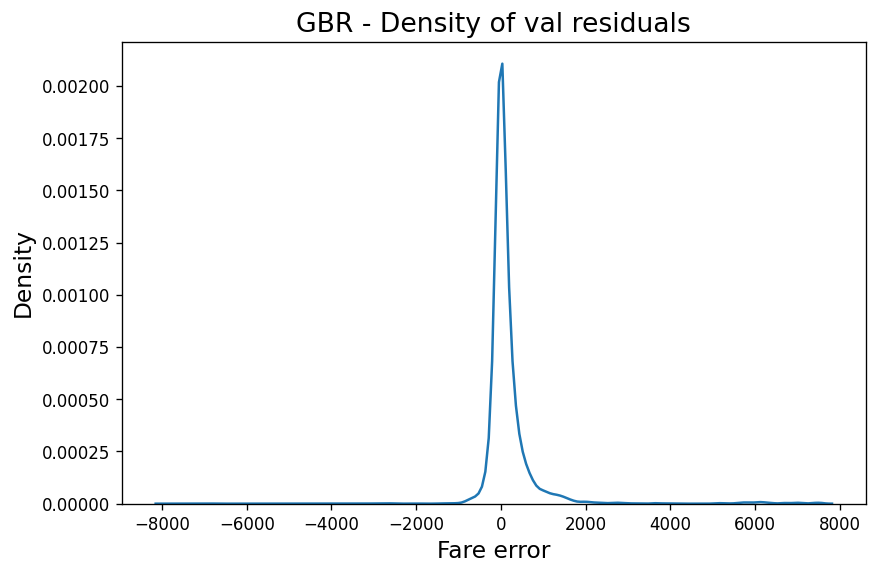

In [44]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.kdeplot(
    val_df['total_fare'] - val_df['pred_fare']
)
plt.title("GBR - Density of val residuals", fontsize = 16)
plt.xlabel("Fare error", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.show()

### Metrics

#### Overall

In [45]:
print_metrics(
    train_df['total_fare'], train_df['pred_fare'],
    label = 'Train - GBR'
)

print_metrics(
    val_df['total_fare'], val_df['pred_fare'],
    label = 'Val - GBR'
)

Train - GBR
RMSE: 282.2022
MAE: 140.9557
R2: 64.972%
Max error: 7353.4236

Val - GBR
RMSE: 754.6193
MAE: 280.0592
R2: 56.911%
Max error: 7878.3259



#### By carrier

In [46]:
for carrier, df in train_df.group_by(['carrier']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Carrier {carrier[0]}'
    )

Val - Carrier OTH
RMSE: 166.9343
MAE: 81.9248
R2: 82.910%
Max error: 7353.4236

Val - Carrier L1
RMSE: 317.5407
MAE: 167.0500
R2: 64.759%
Max error: 4893.1838

Val - Carrier U1
RMSE: 147.4253
MAE: 88.6429
R2: 73.850%
Max error: 1414.3407

Val - Carrier U3
RMSE: 133.5698
MAE: 93.3330
R2: 58.246%
Max error: 1259.5788

Val - Carrier L2
RMSE: 272.8899
MAE: 108.4387
R2: 62.806%
Max error: 3932.0425

Val - Carrier L3
RMSE: 379.3099
MAE: 221.6266
R2: 34.090%
Max error: 2084.8968



In [47]:
for carrier, df in val_df.group_by(['carrier']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Carrier {carrier[0]}'
    )

Val - Carrier U1
RMSE: 220.7346
MAE: 131.3591
R2: 51.506%
Max error: 1349.6546

Val - Carrier U3
RMSE: 189.7446
MAE: 140.1335
R2: -40.322%
Max error: 608.8227

Val - Carrier L3
RMSE: 600.6981
MAE: 347.0936
R2: 13.297%
Max error: 2319.6329

Val - Carrier OTH
RMSE: 2338.6611
MAE: 1112.8253
R2: 47.921%
Max error: 7878.3259

Val - Carrier L2
RMSE: 224.5805
MAE: 144.7780
R2: 56.372%
Max error: 2253.1503

Val - Carrier L1
RMSE: 357.7805
MAE: 221.7074
R2: 47.494%
Max error: 4055.4351



#### By route

In [48]:
for route_id, df in train_df.group_by(['route_id']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Route {route_id[0]}'
    )

Val - Route 3
RMSE: 286.4435
MAE: 179.2743
R2: 72.995%
Max error: 3706.1293

Val - Route 9
RMSE: 310.6675
MAE: 157.7085
R2: 65.392%
Max error: 3659.9983

Val - Route 6
RMSE: 263.7454
MAE: 118.6562
R2: 48.893%
Max error: 7353.4236

Val - Route 0
RMSE: 295.5358
MAE: 159.8558
R2: 56.998%
Max error: 4333.4197

Val - Route 1
RMSE: 431.9410
MAE: 220.6973
R2: 50.222%
Max error: 4489.6793

Val - Route 4
RMSE: 294.5871
MAE: 136.1499
R2: 51.343%
Max error: 4650.5764

Val - Route 10
RMSE: 309.8764
MAE: 163.8032
R2: 67.089%
Max error: 3500.4662

Val - Route 7
RMSE: 320.4391
MAE: 162.1000
R2: 52.676%
Max error: 4893.1838

Val - Route 2
RMSE: 298.2880
MAE: 187.6217
R2: 64.572%
Max error: 4058.9539

Val - Route 11
RMSE: 207.1121
MAE: 109.9112
R2: 61.202%
Max error: 3058.6978

Val - Route 8
RMSE: 455.2552
MAE: 259.5317
R2: 50.573%
Max error: 4235.0859

Val - Route 5
RMSE: 230.1432
MAE: 125.0518
R2: 65.918%
Max error: 3138.5417



In [49]:
for route_id, df in val_df.group_by(['route_id']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Route {route_id[0]}'
    )

Val - Route 3
RMSE: 334.5882
MAE: 231.1757
R2: 62.891%
Max error: 1824.3948

Val - Route 0
RMSE: 214.8000
MAE: 151.5566
R2: 12.083%
Max error: 1096.3775

Val - Route 9
RMSE: 288.1406
MAE: 210.9293
R2: 48.682%
Max error: 1387.9705

Val - Route 6
RMSE: 1011.9095
MAE: 381.1667
R2: 65.187%
Max error: 7878.3259

Val - Route 7
RMSE: 454.1000
MAE: 316.2675
R2: -6.385%
Max error: 2293.2330

Val - Route 10
RMSE: 260.4650
MAE: 175.7714
R2: 56.419%
Max error: 1536.5224

Val - Route 4
RMSE: 1213.0368
MAE: 385.7608
R2: 50.381%
Max error: 7546.9820

Val - Route 1
RMSE: 668.4519
MAE: 473.3454
R2: -35.358%
Max error: 2921.4479

Val - Route 2
RMSE: 319.7630
MAE: 224.8711
R2: 64.765%
Max error: 4055.4351

Val - Route 5
RMSE: 135.8769
MAE: 89.2034
R2: 80.721%
Max error: 1961.5765

Val - Route 11
RMSE: 351.3696
MAE: 217.8054
R2: 31.128%
Max error: 2573.8456

Val - Route 8
RMSE: 555.4664
MAE: 447.6303
R2: -55.199%
Max error: 1975.8706



### Feature importances

In [50]:
pl.DataFrame({
    "Feature": best_model['gbr'].feature_names_in_,
    "FI": (best_model['gbr'].feature_importances_ * 100).round(2)
}).sort("FI", descending = True)

Feature,FI
str,f64
"""remainder__days_till_flight""",33.12
"""remainder__7d_route_carrier_av…",13.68
"""remainder__14d_route_avg""",13.13
"""remainder__days_since_start""",7.8
"""remainder__flt_count_dpt_24h""",6.0
"""remainder__7d_route_avg""",5.34
"""remainder__flt_departure_weekd…",4.57
"""remainder__dpt_4h_od""",4.51
"""remainder__dur_min""",1.95
